In [1]:
import sys


# add workspace root directory to Python path for local imports
workspace_root = '/home/workspace'
if workspace_root not in sys.path:
    sys.path.append(workspace_root)

from scripts.plots import *
from scripts.utils import *

In [2]:
ARCHITECTURE_CHOICE = 'simple'
SUB_ARCHITECTURES = ['AQFP', 'CMOS_7nm']

WORKLOAD_CHOICE = 'gpt2_medium'
BATCH_SIZE = 8

if not SUB_ARCHITECTURES:
    SUB_ARCHITECTURES = [os.path.basename(f).rsplit('.', 1)[0] for f in glob.glob(f'../models/architectures/{ARCHITECTURE_CHOICE}/*.yaml')]

print(f'Architecture: {ARCHITECTURE_CHOICE} {", ".join(SUB_ARCHITECTURES)}')
print(f'Workload: {WORKLOAD_CHOICE}')

Architecture: simple AQFP, CMOS_7nm
Workload: gpt2_medium


In [33]:
def test_full_dnn(
    dnn_name,
    return_per_layer=False,
    **kwargs
):
    # Many of the layerse have the same shape, so this code runs each unique shape once
    # and then copies the result for the other layers with the same shape.
    all_yamls = sorted(os.listdir(f"../models/workloads/{dnn_name}"))
    all_yamls = [f for f in all_yamls if f.endswith('.yaml')]
    yaml2content = {}
    for yaml in all_yamls:
        with open(f"../models/workloads/{dnn_name}/{yaml}", 'r') as f:
            yaml2content[yaml] = f.read()
    content2yamls = {}
    for yaml, content in yaml2content.items():
        content2yamls.setdefault(content, []).append(yaml)
        
    results = parallel(
        delayed(generate_result)(
            layer=yamls[0],
            **kwargs
        )
        for yamls in content2yamls.values()
    )
    
    yaml2result = {}
    for yamls, result in zip(content2yamls.values(), results):
        for yaml in yamls:
            yaml2result[yaml] = result
            
    yaml2result_sorted = {
        yaml: yaml2result[yaml] for yaml in all_yamls
    }
            
    if return_per_layer:
        return yaml2result_sorted
    result = tl.OutputStats.aggregate(list(yaml2result_sorted.values()))
    print(f'Total computes: {result.computes}')
    return result

## 4Kb register and single MAC

In [34]:
kwargs = dict(
    architecture=ARCHITECTURE_CHOICE,
    workload=WORKLOAD_CHOICE,
    n_macs=1,
    reg_depth=128, # 4Kb RF
    reg_width=32,  
    batch_size=BATCH_SIZE,
)

results = {}
for sub_architecture in SUB_ARCHITECTURES:
    results[sub_architecture] = test_full_dnn(
        WORKLOAD_CHOICE, 
        sub_architecture=sub_architecture,
        **kwargs
    )
energy_per_compute = {k:v.per_compute('per_component_energy') for k,v in results.items()}
area = {k:v.per_component_area for k,v in results.items()}
[area[k].pop("main memory", None) for k in area.keys()] 
# remove main memory from area because it's capacity was arbitrarily set

100%|██████████| 7/7 [00:00<00:00, 3184.74it/s]


Total computes: 724123516928


100%|██████████| 7/7 [00:00<00:00, 6877.52it/s]


Total computes: 724123516928


[17454747090.944, None]

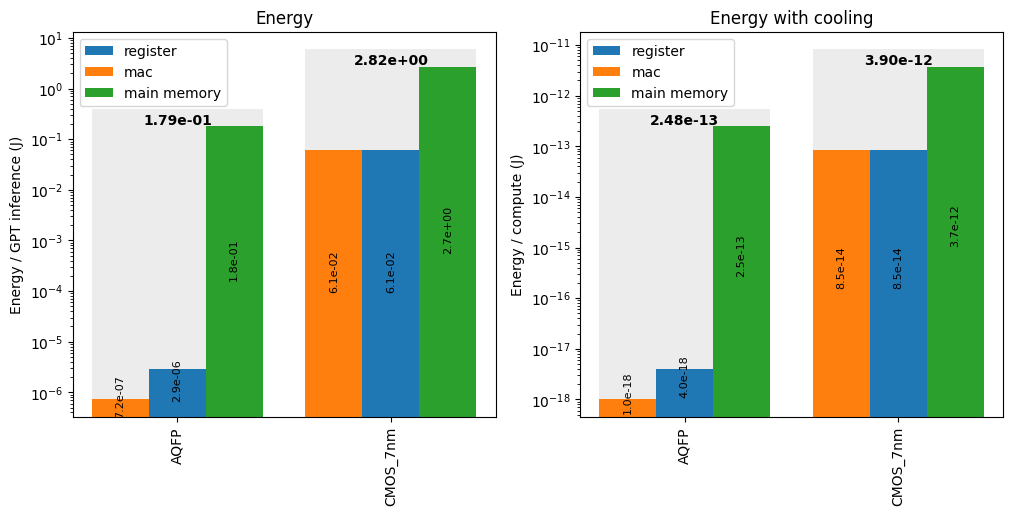

In [37]:
energy_by_component = {k:v.per_component_energy for k,v in results.items()}

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
bar_side_by_side(energy_by_component, ylabel="Energy / GPT inference (J)", title="Energy", yscale="log", ax=axs[0], legend_ncol=1, missing_ok=True, log_bottom=1e-6, total_label_multiplier=1.1, gray_multiplier=2.2)
bar_side_by_side(energy_per_compute, ylabel="Energy / compute (J)", title="Energy with cooling", yscale="log", ax=axs[1], legend_ncol=1, missing_ok=True, log_bottom=2e-18, total_label_multiplier=1.1, gray_multiplier=2.2)


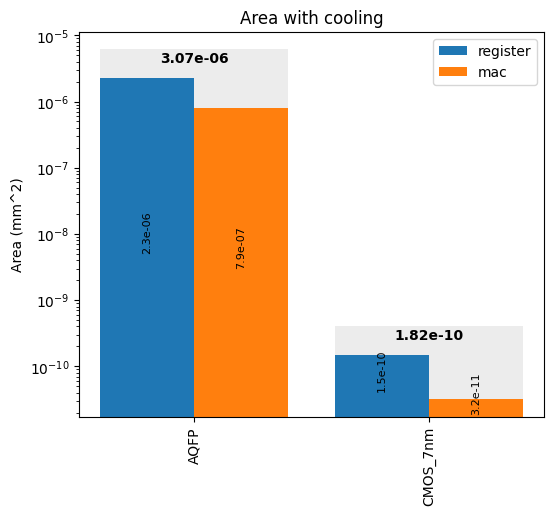

In [38]:
fig, axs = plt.subplots(1, 1, figsize=(6, 5))
bar_side_by_side(area, ylabel="Area (mm^2)", title="Area with cooling", yscale="log", ax=axs, legend_ncol=1, missing_ok=True, log_bottom=5e-11, total_label_multiplier=1.7, gray_multiplier=2.7)

## 1Mb register and single MAC

In [27]:
kwargs = dict(
    architecture=ARCHITECTURE_CHOICE,
    workload=WORKLOAD_CHOICE,
    n_macs=1,
    reg_depth=128*256,  # 1Mb RF
    reg_width=32,  
    batch_size=BATCH_SIZE
)

results = {}
for sub_architecture in SUB_ARCHITECTURES:
    results[sub_architecture] = test_full_dnn(
        WORKLOAD_CHOICE, 
        sub_architecture=sub_architecture,
        **kwargs
    )
energy_per_compute = {k:v.per_compute('per_component_energy') for k,v in results.items()}
area = {k:v.per_component_area for k,v in results.items()}
[area[k].pop("main memory", None) for k in area.keys()] 
# remove main memory from area because it's capacity was arbitrarily set

100%|██████████| 7/7 [00:00<00:00, 1464.49it/s]


Total computes: 724123516928


100%|██████████| 7/7 [00:00<00:00, 7226.22it/s]


Total computes: 724123516928


[17454747090.944, None]

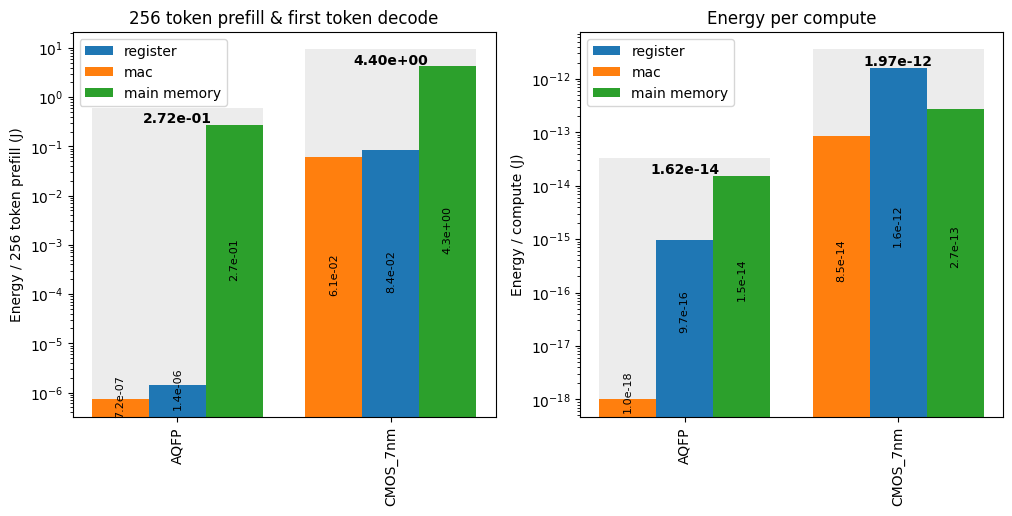

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
bar_side_by_side(energy_by_component, ylabel="Energy / 256 token prefill (J)", title="GPT-2 256-token prefill & 1-token decode", yscale="log", ax=axs[0], legend_ncol=1, missing_ok=True, log_bottom=1e-6, total_label_multiplier=1.1, gray_multiplier=2.2)
bar_side_by_side(energy_per_compute, ylabel="Energy / compute (J)", title="Energy per compute", yscale="log", ax=axs[1], legend_ncol=1, missing_ok=True, log_bottom=2e-18, total_label_multiplier=1.1, gray_multiplier=2.2)

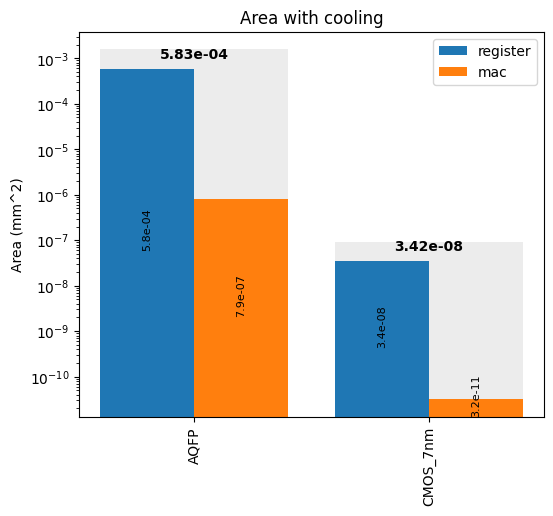

In [32]:
fig, axs = plt.subplots(1, 1, figsize=(6, 5))
bar_side_by_side(area, ylabel="Area (mm^2)", title="Area with cooling", yscale="log", ax=axs, legend_ncol=1, missing_ok=True, log_bottom=5e-11, total_label_multiplier=1.7, gray_multiplier=2.7)

## 1Mb register and 32 MACs

In [40]:
kwargs = dict(
    architecture=ARCHITECTURE_CHOICE,
    workload=WORKLOAD_CHOICE,
    n_macs=32,
    reg_depth=128*256,  # 1Mb RF
    reg_width=32,  
    batch_size=BATCH_SIZE
)

results = {}
for sub_architecture in SUB_ARCHITECTURES:
    results[sub_architecture] = test_full_dnn(
        WORKLOAD_CHOICE, 
        sub_architecture=sub_architecture,
        **kwargs
    )
energy_per_compute = {k:v.per_compute('per_component_energy') for k,v in results.items()}
area = {k:v.per_component_area for k,v in results.items()}
[area[k].pop("main memory", None) for k in area.keys()] 
# remove main memory from area because it's capacity was arbitrarily set

100%|██████████| 7/7 [00:00<00:00, 2876.75it/s]


Total computes: 724123516928


100%|██████████| 7/7 [00:00<00:00, 4652.95it/s]


Total computes: 724123516928


[17454747090.944, None]

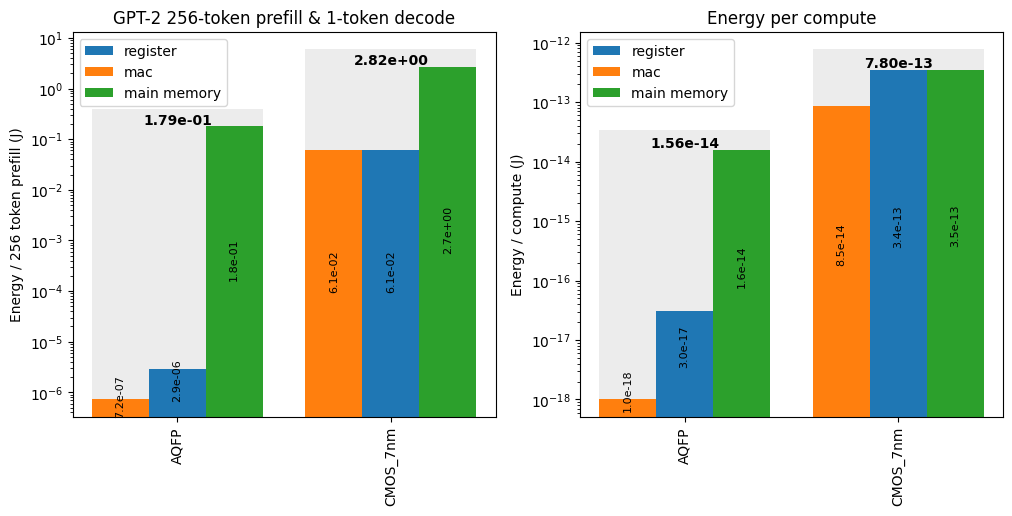

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
bar_side_by_side(energy_by_component, ylabel="Energy / 256 token prefill (J)", title="GPT-2 256-token prefill & 1-token decode", yscale="log", ax=axs[0], legend_ncol=1, missing_ok=True, log_bottom=1e-6, total_label_multiplier=1.1, gray_multiplier=2.2)
bar_side_by_side(energy_per_compute, ylabel="Energy / compute (J)", title="Energy per compute", yscale="log", ax=axs[1], legend_ncol=1, missing_ok=True, log_bottom=2e-18, total_label_multiplier=1.1, gray_multiplier=2.2)

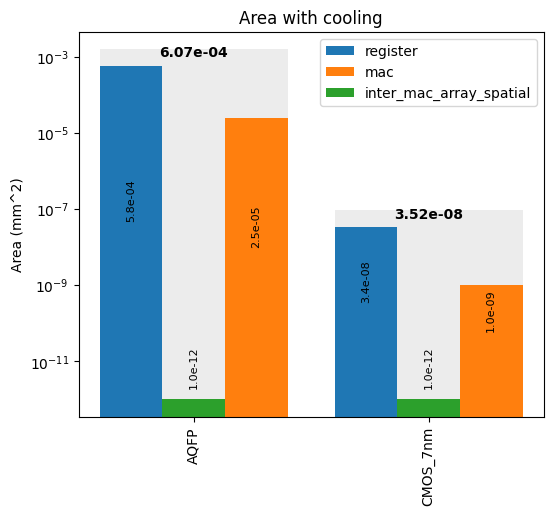

In [44]:
fig, axs = plt.subplots(1, 1, figsize=(6, 5))
bar_side_by_side(area, ylabel="Area (mm^2)", title="Area with cooling", yscale="log", ax=axs, legend_ncol=1, missing_ok=True, log_bottom=5e-11, total_label_multiplier=1.7, gray_multiplier=2.7)